<h1 style="text-align:center;font-size:30px;" > Quora Duplicate Question Prediction </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. </p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h1>2. Machine Learning Problem</h1>

<h2> 2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.1.1 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.2 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
!pip install fuzzywuzzy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import os

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
os.getcwd()

'/Users/snehamehrin/Desktop/Data Analytics/AppliedAiCaseStudies/Quora'

<h2> 3.1 Reading data and basic stats </h2>

In [3]:
#Read data
df=pd.read_csv('train.csv')
print('Number of data points {}'.format(df.shape[0]))

Number of data points 404290


In [4]:
#Print first five data points to get a feel of the data
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
#Print the datatypes of different columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

In [6]:
#Check if there is any null value
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

<h3>Observations</h3>

<p>It looks like question1 and question2 has null values. Let's explore them more.
Our approach should be to fill them with 0,so that we can feature engineer them</p>

In [7]:
#Check which question2 has null values
df.loc[df['question2'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

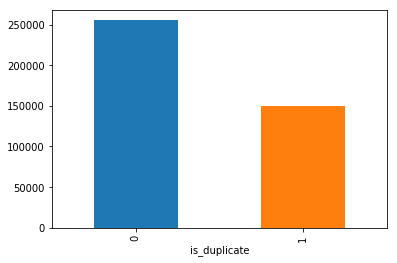

In [8]:

df.groupby('is_duplicate')['id'].count().plot.bar()

In [9]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [10]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(np.round(df['is_duplicate'].value_counts(normalize=True)[0]*100),3))
print('~> Question pairs are  Similar (is_duplicate = 1):\n   {}%'.format(np.round(df['is_duplicate'].value_counts(normalize=True)[1]*100),3))



~> Question pairs are not Similar (is_duplicate = 0):
   63.0%
~> Question pairs are  Similar (is_duplicate = 1):
   37.0%


<h3> 3.2.2 Number of unique questions </h3>

In [11]:
#Find the total number of unique questions

total_question_ids=pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
total_questions_len=len(np.unique(total_question_ids))

print("Total Number of Questions {}".format(total_questions_len))
#Find the number of questions which occurs more than once

qs_more_than_onetime=np.sum(total_question_ids.value_counts()>1)
print("Questions which appears more than once {} which accounts to about {}% of the total data".format(qs_more_than_onetime,round((qs_more_than_onetime/total_questions_len)*100),2))
#Maximum time a question is repeated

max_question_repeated=total_question_ids.value_counts().values[0]
print("Maximum times a question is repeated {}".format(max_question_repeated))

Total Number of Questions 537933
Questions which appears more than once 111780 which accounts to about 21.0% of the total data
Maximum times a question is repeated 157


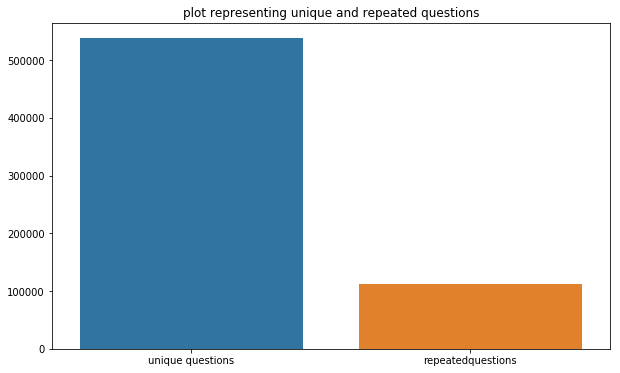

In [12]:
#Plot for unique and repeated questions
x=['unique questions','repeatedquestions']
y=[total_questions_len,qs_more_than_onetime]

plt.figure(figsize=(10,6))
plt.title('plot representing unique and repeated questions')
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [13]:
#checking whether there are any repeated pair of questions
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('Duplicate Questions are {}'.format(pair_duplicates.shape[0]-df.shape[0]))

Duplicate Questions are 0


<h3> 3.2.4 Number of occurrences of each question </h3>


Maximum number of times a single question is repeated: 157



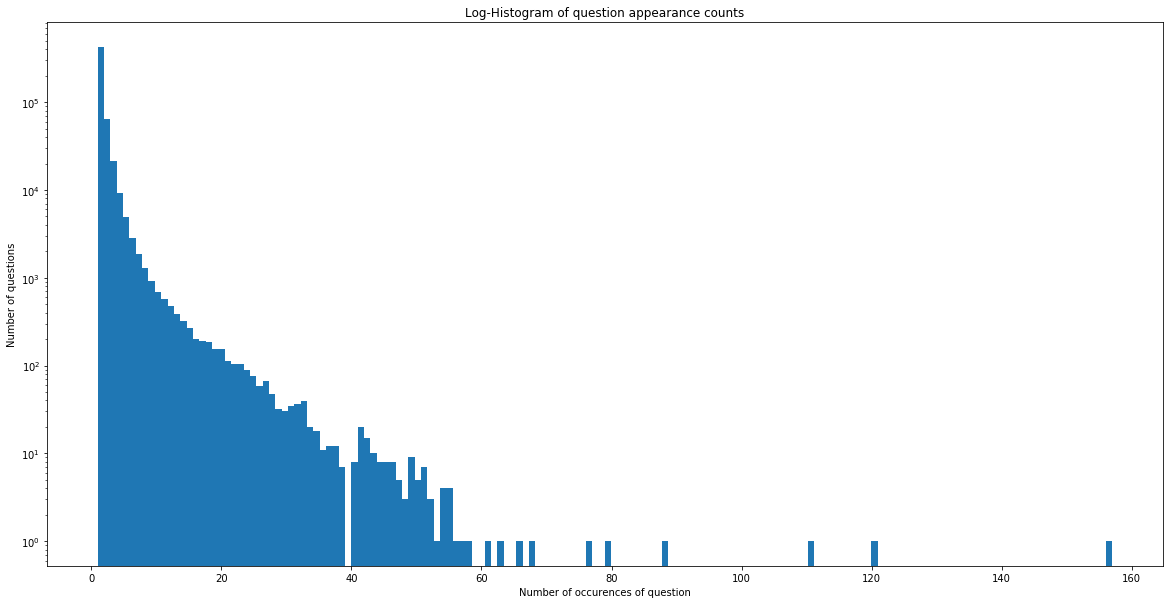

In [14]:
plt.figure(figsize=(20, 10))

plt.hist(total_question_ids.value_counts(), bins=160)
plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(total_question_ids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [15]:
df=df.fillna(' ')

<h2>3.3 Basic Feature Extraction  </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [16]:
#Convert question1 and question2 to str
df['question1']=df['question1'].astype(str)
df['question2']=df['question2'].astype(str)

In [17]:
df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
df['q1len']=df['question1'].str.len()
df['q2len']=df['question2'].str.len()
df['q1_n_words']=df['question1'].astype(str).apply(lambda x : len(x.split(" ")))
df['q2_n_words']=df['question2'].astype(str).apply(lambda x : len(x.split(" ")))

In [18]:
def find_common_words(row):
    no_words_question1=set(map(lambda word : word.lower(),row['question1'].split(" ")))
    no_words_question2=set(map(lambda word : word.lower(),row['question2'].split(" ")))
    return 1.0 * len(no_words_question1 & no_words_question2)
df['word_common']=df.astype('str').apply(find_common_words,axis=1)

In [19]:
def find_total_words(row):
    no_words_question1=set(map(lambda word : str(word).lower(),row['question1'].split(" ")))
    no_words_question2=set(map(lambda word : str(word).lower(),row['question2'].split(" ")))
    return 1.0 * (len(no_words_question1) + len(no_words_question2))

df['word_Total']= df.apply(find_total_words,axis=1)

In [20]:
def word_share(row):
    no_words_question1=set(map(lambda word : str(word).lower(),row['question1'].split(" ")))
    no_words_question2=set(map(lambda word : str(word).lower(),row['question2'].split(" ")))
    return (1.0 * len(no_words_question1 & no_words_question2))/(1.0 * (len(no_words_question1) + len(no_words_question2)))

df['word_share']= df.apply(word_share,axis=1)

In [21]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
#write this into a file
df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()
    

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

In [22]:
print('Minimum length of question1 {}'.format(min(df['q1len'])))
print('Minimum length of question2 {}'.format(min(df['q2len'])))
print('Number of Questions with minimum length [question1] :'.format(df[df['q1len']==1.0].shape[0]))
print('Number of Questions with minimum length [question2] :'.format(df[df['q2len']==1.0].shape[0]))

Minimum length of question1 1
Minimum length of question2 1
Number of Questions with minimum length [question1] :
Number of Questions with minimum length [question2] :


<h4> 3.3.1.1 Feature: word_share </h4>

/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


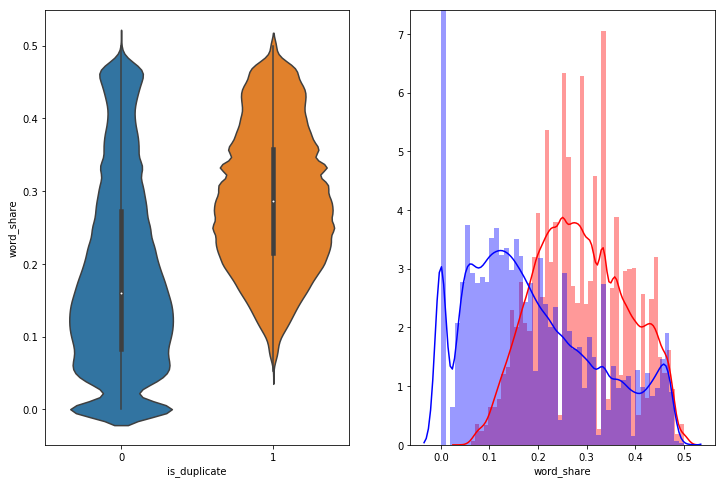

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


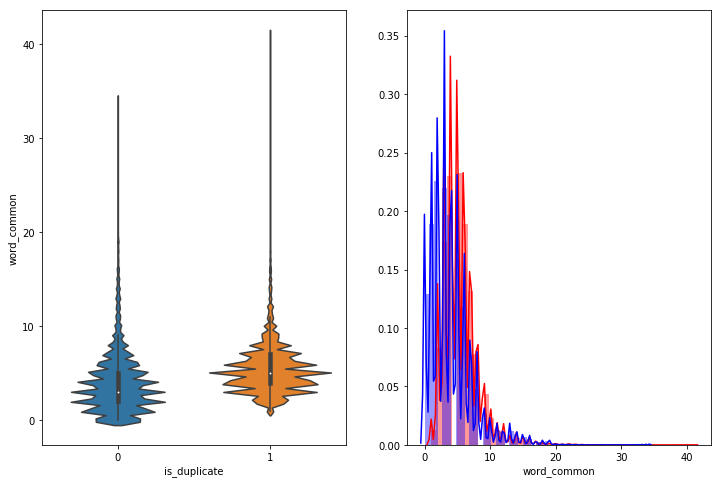

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

### 4 EDA: Advanced Feature Extraction.

<h2> 4.1 Preprocessing of Text </h2>

In [25]:
#Load the file run as part of previous steps
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df=pd.read_csv('df_fe_without_preprocessing_train.csv',encoding='latin-1')
    df=df.fillna(' ')
else:
    print('File does not exist or run the previous steps first')

In [26]:
def preprocess(x):
    SAFE_DIV = 0.0001 
    STOP_WORDS = stopwords.words("english")
    #Convert to lowercase
    x=str(x).lower()
    #Replace contractions
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x=re.sub(r'([0-9]+)000000',r'\1m',x)
    x=re.sub(r'([0-9]+)000',r'\1k',x)
    
    #replace any non-word character
    x=re.sub(r'\W+',' ',x)
    
    #Stemming
    porter = PorterStemmer()
    x=porter.stem(x)
    
    return x

<h2> 4.2 Advanced Feature Extraction</h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>



In [27]:

def get_token_features(q1,q2):
    SAFE_DIV = 0.0001 
    STOP_WORDS = stopwords.words("english")
    token_features =[0.0]*10
    
    q1_tokens=q1.split()
    q2_tokens=q2.split()
    
    #If leng
    if len(q1_tokens)==0 or len(q2_tokens)==0 :
        token_features=[0.0]*10
    else:
        #Get the non-stop words in questions
        q1_words=set([word for word in q1 if word not in STOP_WORDS])
        q2_words=set([word for word in q2 if word not in STOP_WORDS])
        #Get the stop words in questions
        q1_stop=set([word for word in q1 if word in STOP_WORDS])
        q2_stop=set([word for word in q2 if word in STOP_WORDS])
        #Get the common non-stop words
        common_word_count=len(q1_words.intersection(q2_words))
        #Get the common stop words in questions
        common_stop_count=len(q1_stop.intersection(q2_stop))
        #Get the common token pairs
        common_token_count=len(set(q1_tokens).intersection(set(q2_tokens)))
        #Token Features
        token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
        token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
        token_features[2] = common_stop_count / (min(len(q1_stop), len(q2_stop)) + SAFE_DIV)
        token_features[3] = common_stop_count / (max(len(q1_stop), len(q2_stop)) + SAFE_DIV)
        token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
        token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
        #Last word of both question is same or not
        token_features[6]=int(q1_tokens[-1]==q2_tokens[-1])
        #First word of both question is same or not
        token_features[7]=int(q1_tokens[0]==q2_tokens[0])
        token_features[8]=abs(len(q1_tokens)-len(q2_tokens))
        #Average token length of both questions
        token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features
    

In [28]:
def extract_features(df):
    #pre-process each question
    df['question1']=df['question1'].fillna('').apply(preprocess)
    df['question2']=df['question2'].fillna('').apply(preprocess)
    
    token_features=df.apply(lambda x : get_token_features(x['question1'],x['question2']),axis=1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    
    return df

In [29]:
#Load the features into a dataset nlp features
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999992,0.999992,0.999988,0.999988,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.999988,0.533330,0.999986,0.874989,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,65,73


<h3>4.3 Analysis of extracted features </h3>

<h4> 4.3.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [30]:
df_duplicate=df[df['is_duplicate']==1]
df_nonduplicate=df[df['is_duplicate']==0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
text_duplicate = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
text_nonduplicate= np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()


print ("Total number of words in duplicate pair questions :",len(text_duplicate))
print ("Total number of words in non duplicate pair questions :",len(text_nonduplicate))

#Saving the np array into a text file
np.savetxt('train_p.txt', text_duplicate, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', text_nonduplicate, delimiter=' ', fmt='%s')

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510054


In [31]:
# reading the text files
from os import path
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16040697
Total number of words in non duplicate pair questions : 32906904


__ Word Clouds generated from  duplicate pair question's text __

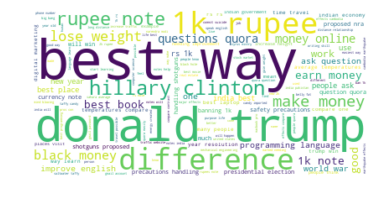

In [32]:
from wordcloud import WordCloud, STOPWORDS
wc=WordCloud(background_color='white',max_words=len(textp_w))
wc.generate(textp_w)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

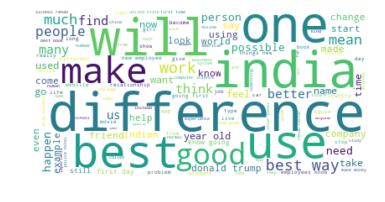

In [33]:
wc=WordCloud(background_color='white',max_words=len(textn_w))
wc.generate(textn_w)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

<h4> 4.3.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

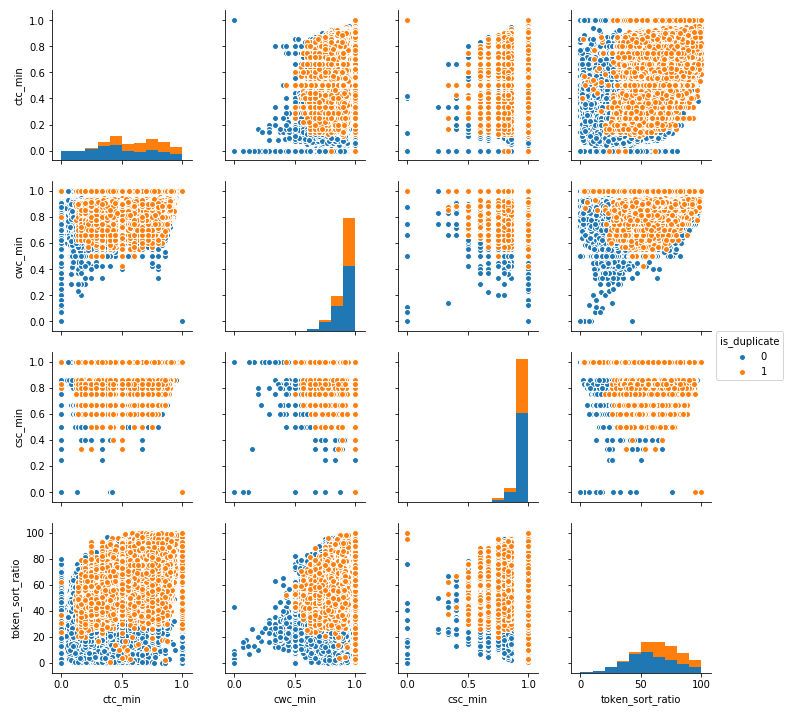

In [34]:
n=df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n],hue='is_duplicate',vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

Observations

-There is a partial seperation between duplicate and non duplicate questions
-from univariate analysis also we can see, higher token seperation is for duplicated questions

/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


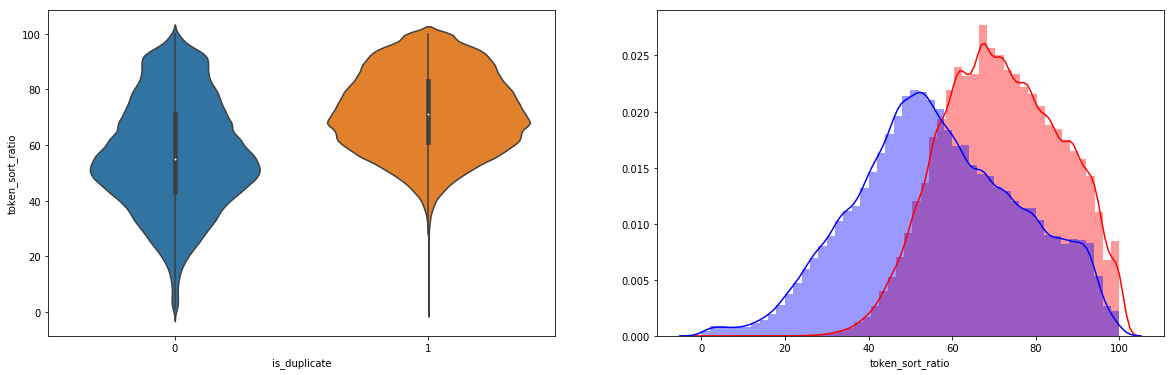

In [35]:
#Distribution of tokensort ratio
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='token_sort_ratio',data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['token_sort_ratio'],label='1',color='red')
sns.distplot(df[df['is_duplicate']==0.0]['token_sort_ratio'],label='0',color='blue')

/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/snehamehrin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


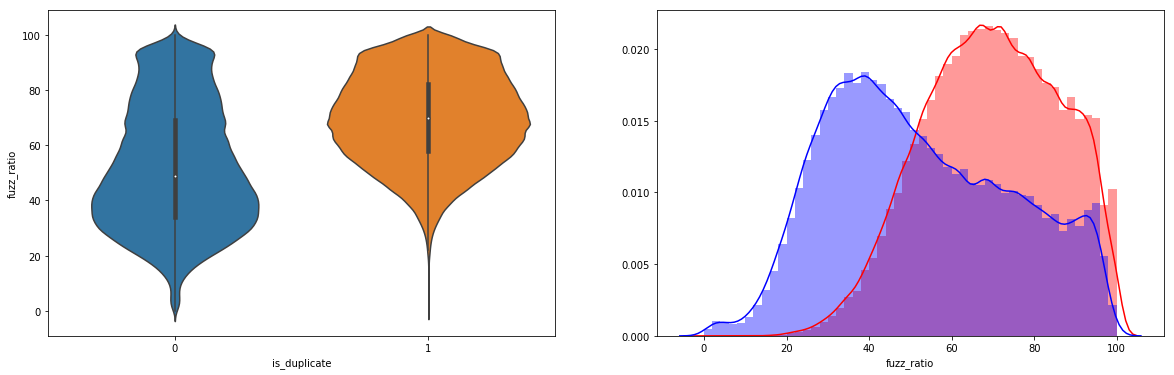

In [36]:
#Distribution of fuzz ratio
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='fuzz_ratio',data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['fuzz_ratio'],label='1',color='red')
sns.distplot(df[df['is_duplicate']==0.0]['fuzz_ratio'],label='0',color='blue')

###Observations

-Violin plot and Probability plot shows that there is a definite value for these features
-Violin plot does not overlap and also token sort ratio and fuzz ratio is higher for duplicated questions

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity


In [37]:
#Load the previous notebook files
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [38]:
#Drop Unwanted fields
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [39]:
df3.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,0.999992,0.999992,0.999988,0.999988,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,0.999988,0.533330,0.999986,0.874989,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,65,73
2,2,0.833326,0.769225,0.999986,0.874989,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47
3,3,0.777769,0.583328,0.857131,0.857131,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14
4,4,0.909083,0.666662,0.999983,0.749991,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,36,56


<h1>6. Machine Learning Models </h1>

<h2> 6.1 Reading data from file and storing into sql table </h2>

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [41]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    #chunksize make sure that data is loaded in chunks,instead of reading the whole data
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [42]:
if os.path.isfile('train.db'):
    conn = sqlite3.connect('train.db')
    if conn is not None:
        #For selecting random points
        df=pd.read_sql_query("SELECT * From data order by Random() limit 100001",conn)

In [43]:
#Get the y values
y_true=df['is_duplicate'].values
#Cleanup the data set by removing unwanted columns
df.drop(columns=['index','Unnamed: 0','id','is_duplicate'],inplace=True)

<h2> 6.2 Converting strings to numerics </h2>

In [44]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
column=df.columns

for col in column:
    df[col]=df[col].apply(pd.to_numeric)

In [45]:
#Convert the y values into string as well
y_true=list(map(int,y_true))

<h2> 6.3 Random train test split( 70:30) </h2>

In [47]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [48]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30001, 794)


In [49]:
print('-'*10,'Distribution of output variable in Train data','-'*10)

print(pd.Series(y_train).value_counts(normalize=True))

print('-'*10,'Distribution of output variable in Test data','-'*10)
print(pd.Series(y_test).value_counts(normalize=True))

---------- Distribution of output variable in Train data ----------
0    0.630857
1    0.369143
dtype: float64
---------- Distribution of output variable in Test data ----------
0    0.630846
1    0.369154
dtype: float64


In [50]:
#plot the confusion matrix

def plot_confusion_matrix(y_test,predicted_y):
    '''
     This function plots the confusion matrix of the actual y values and predicted y values
     Input : Y_test and Y_predicted
     Output:Heatmap 3*3 matrix of TP,TN,FP and FN values
    
    '''
    C=confusion_matrix(y_test,predicted_y)
    #Plot heatmap of the confusion matrix
    labels=[0,1]
    cmap=sns.light_palette('blue')
    sns.heatmap(C,cmap=cmap,fmt='0.3f',annot=True,xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

<h2> 6.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5497496595302849
For values of alpha =  0.0001 The log loss is: 0.5244319502868356
For values of alpha =  0.001 The log loss is: 0.5196819161327523
For values of alpha =  0.01 The log loss is: 0.5322422867894645
For values of alpha =  0.1 The log loss is: 0.5200300312928746
For values of alpha =  1 The log loss is: 0.509445010671738
For values of alpha =  10 The log loss is: 0.5209563241782293


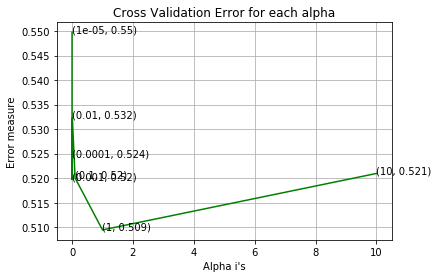

For values of best alpha =  1 The train log loss is: 0.5005020371038232
For values of best alpha =  1 The test log loss is: 0.509445010671738
Total number of data points : 30001


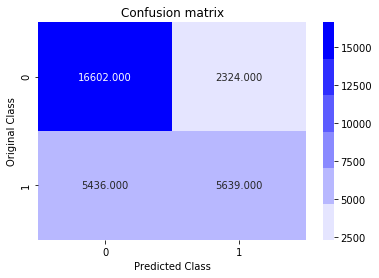

In [51]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    #Use Calibrated classifier to predict the probabilities instead of actual class values
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    #Append the log loss to an array
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 6.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5869745041762856
For values of alpha =  0.0001 The log loss is: 0.49288474196282284
For values of alpha =  0.001 The log loss is: 0.520938953181579
For values of alpha =  0.01 The log loss is: 0.5693390524673004
For values of alpha =  0.1 The log loss is: 0.6058239425098966
For values of alpha =  1 The log loss is: 0.6421056971209415
For values of alpha =  10 The log loss is: 0.6567372955720292


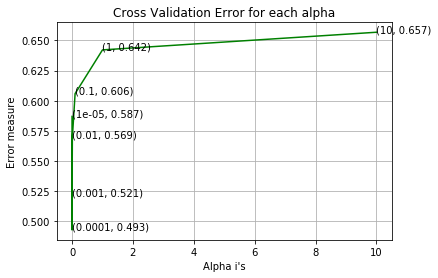

For values of best alpha =  0.0001 The train log loss is: 0.47892922889222506
For values of best alpha =  0.0001 The test log loss is: 0.49288474196282284
Total number of data points : 30001


In [52]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
#plot_confusion_matrix(y_test, predicted_y)

<h2> 6.6 X-G BOOST </h2>

In [55]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[16:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.684619	valid-logloss:0.684734
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[16:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:59] src/

[16:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[70]	train-logloss:0.438858	valid-logloss:0.44383
[16:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:33:40] src/tree/updater_prune.cc:74: tree pruning 

[16:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[140]	train-logloss:0.386949	valid-logloss:0.394212
[16:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:41:09] src/tree/updater_prune.cc:74: tree prunin

[16:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:48:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[210]	train-logloss:0.368301	valid-logloss:0.377485
[16:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:48:55] src/tree/updater_prune.cc:74: tree prunin

[16:55:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[280]	train-logloss:0.356483	valid-logloss:0.367898
[16:55:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:55:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[16:56:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:56:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[16:56:24] src/tree/updater_prune.cc:74: tree prunin

[17:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[350]	train-logloss:0.347043	valid-logloss:0.360912
[17:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[17:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:04:12] src/tree/updater_prune.cc:74: tree prunin